In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess data

In [2]:
# For text cleaning

HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
]

RE_EMAIL = re.compile('<?.*@.*>?', re.M)
RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
RE_HEADERS = re.compile('^(%s):.*$' % '|'.join(HEADERS), re.M|re.I)
STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

TEXT_LENS = []

def load():
    ng = fetch_20newsgroups(subset='all', shuffle=False)

    return pd.DataFrame.from_dict({
        'text': _clean(ng.data),
        'group': np.take(ng.target_names, ng.target)
    })

def _clean(docs):
    docs = map(rm_headers, docs)
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_email, docs)
    docs = map(rm_nums, docs)
    docs = map(rm_line_break, docs)
    docs = map(to_lower, docs)
    docs = map(rm_stopwords, docs)
    docs = map(rm_too_short_long, docs)
    docs = map(stem_words, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_email(doc):
    return RE_EMAIL.sub('<email>', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_headers(doc):
    return RE_HEADERS.sub('', doc)

# addition
def rm_nums(doc):
    return re.sub('[^a-zA-Z]', ' ', doc)

def rm_files(doc):
    if doc.find('begin') > -1:
        if doc.find('end') > -1:
            doc = doc[0:doc.find('begin')] + doc[doc.find('end')+3:]
    return doc

def to_lower(doc):
    return doc.lower()

def rm_stopwords(doc):
    doc = doc.split()
    doc = [w for w in doc if not w in STOP_WORDS]
    return ' '.join(doc)

def rm_too_short_long(doc):
    doc = doc.split()
    doc = [w for w in doc if len(w) >=3 and len(w) <= 15]
    return ' '.join(doc)

def stem_words(doc):
    doc = doc.split()
    doc = [STEMMER.stem(w) for w in doc]
    TEXT_LENS.append(len(doc))
    return ' '.join(doc)

In [3]:
data = load()

In [4]:
data

,text,group
0,morgan guzman era run higher last year cub idi...,rec.sport.baseball
1,well got centri yesterday took two week place ...,comp.sys.mac.hardware
2,histori classic method modern method survey re...,sci.crypt
3,attent mac quadra owner mani storag industri e...,comp.sys.mac.hardware
4,show exampl other provid counter exampl suppos...,alt.atheism
...,...,...
18841,circuit board green materi use make goe two na...,sci.electronics
18842,bike luckili guy stop foot behind rear wheel u...,rec.motorcycles
18843,told resolut fge could could anybodi tri run h...,comp.sys.mac.hardware
18844,cad setup sale plb local bu motherboard use si...,misc.forsale


# Split all data into train and test set

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.group)

#### Train Set:

In [6]:
train.shape

(15076, 2)

#### Test Set:

In [7]:
test.shape

(3770, 2)

#### Train-Set label distribution:

In [8]:
train.group.value_counts()

rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
sci.med                     792
rec.autos                   792
sci.space                   790
comp.windows.x              790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64

#### Test-Set label distribution

In [9]:
test.group.value_counts()

rec.sport.hockey            200
rec.sport.baseball          199
soc.religion.christian      199
rec.motorcycles             199
sci.med                     198
sci.crypt                   198
comp.windows.x              198
rec.autos                   198
comp.os.ms-windows.misc     197
sci.electronics             197
sci.space                   197
comp.sys.ibm.pc.hardware    196
comp.graphics               195
misc.forsale                195
comp.sys.mac.hardware       193
talk.politics.mideast       188
talk.politics.guns          182
alt.atheism                 160
talk.politics.misc          155
talk.religion.misc          126
Name: group, dtype: int64

# Encode text using TF-IDF

In [10]:
# Lenght of the longest text - compute with text cleaning
max(TEXT_LENS)

6004

In [11]:
tfidf = TfidfVectorizer(max_features=max(TEXT_LENS)).fit(train.text)

In [12]:
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys[:10]

[(0, 'aaa'),
 (1, 'aaron'),
 (2, 'ab'),
 (3, 'abandon'),
 (4, 'abc'),
 (5, 'abid'),
 (6, 'abil'),
 (7, 'abl'),
 (8, 'abolish'),
 (9, 'abomin')]

#### Encode train and test sets using same vocabulary

In [13]:
X_train = tfidf.transform(train.text).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_test = tfidf.transform(test.text).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (15076, 6004)
X_test shape: (3770, 6004)


# Convert labels to integer values

#### Fit label encoder:

In [14]:
label_encoder = LabelEncoder().fit(train.group)

#### Known labels:

In [15]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

#### Convert labels using encoder:

In [16]:
Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


# Classification with custom Neural Network

#### Transform Y_train:

In [17]:
Y_train_transf = OneHotEncoder().fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_train_transf.shape

(15076, 20)

In [18]:
class NeuralNet:
    """
    NN for multi-class classification with mini-batch
    Attributes:
    ...
    """    
    def __init__(self, mbgd_size, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.mbgd_size = mbgd_size
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * np.sqrt(1 / neurons_in_layers[i - 1])
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__sigmoid(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__sigmoid(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def __shuffle_and_separate(self, X, Y):            
        m = X.shape[1]
        SS_data = [] #for shuffled and separated data
        mbgd_size = self.mbgd_size
        
        perm = list(np.random.permutation(m))
        shuff_X = X[:, perm]        
        shuff_Y = Y[:, perm]

        for i in range(0, int(np.floor(m/mbgd_size))):
            batch_X = shuff_X[:, i*mbgd_size : (i + 1)*mbgd_size]
            batch_Y = shuff_Y[:, i*mbgd_size : (i + 1)*mbgd_size]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        if m % mbgd_size != 0:
            batch_X = shuff_X[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            batch_Y = shuff_Y[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        return SS_data
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        m = X.shape[1]
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            SS_data = self.__shuffle_and_separate(X, Y)
            
            for (batch_X, batch_Y) in SS_data:
                A, caches = self.__forward_propagation(batch_X)

                cost = self.compute_cost(A, batch_Y)

                grads = self.__backward_propagation(A, batch_Y, caches)

                self.__update_parameters(grads)
            
            costs.append(cost)

            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)

#### Layer dims:

In [19]:
input_layer = X_train.shape[1]
output_layer = Y_train_transf.shape[1]

In [20]:
clf = NeuralNet(mbgd_size = 1024, neurons_in_layers = [input_layer, 40, output_layer], normalize = True, learning_rate = 0.09, num_iter = 50)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


0-th iteration: 0.1380780371764733
10-th iteration: 0.07665032642374642
20-th iteration: 0.05198216566349291
30-th iteration: 0.041560062751271346
40-th iteration: 0.033095811107744275


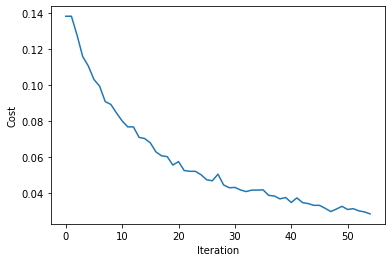

In [21]:
clf.fit(X_train, Y_train_transf)

#### Train report:

In [22]:
Y_train_hat = clf.predict(X_train)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.81      0.82      0.82       639
           comp.graphics       0.81      0.83      0.82       778
 comp.os.ms-windows.misc       0.81      0.81      0.81       788
comp.sys.ibm.pc.hardware       0.80      0.83      0.81       786
   comp.sys.mac.hardware       0.86      0.85      0.85       770
          comp.windows.x       0.87      0.89      0.88       790
            misc.forsale       0.85      0.83      0.84       780
               rec.autos       0.88      0.87      0.87       792
         rec.motorcycles       0.89      0.89      0.89       797
      rec.sport.baseball       0.93      0.93      0.93       795
        rec.sport.hockey       0.94      0.94      0.94       799
               sci.crypt       0.92      0.91      0.92       793
         sci.electronics       0.85      0.84      0.84       787
                 sci.med       0.90      0.92      0

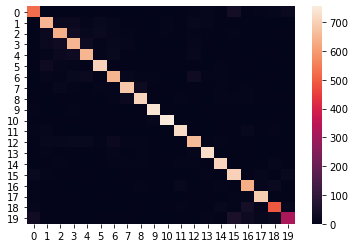

In [23]:
print("Classification report:")
print(classification_report(Y_train, Y_train_hat, target_names=label_encoder.classes_))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_hat)))

#### Test report:

In [24]:
Y_test_hat = clf.predict(X_test)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.61      0.58      0.60       160
           comp.graphics       0.56      0.59      0.58       195
 comp.os.ms-windows.misc       0.57      0.51      0.54       197
comp.sys.ibm.pc.hardware       0.56      0.56      0.56       196
   comp.sys.mac.hardware       0.58      0.62      0.60       193
          comp.windows.x       0.67      0.71      0.69       198
            misc.forsale       0.64      0.56      0.60       195
               rec.autos       0.71      0.62      0.66       198
         rec.motorcycles       0.68      0.74      0.71       199
      rec.sport.baseball       0.78      0.82      0.80       199
        rec.sport.hockey       0.88      0.82      0.85       200
               sci.crypt       0.77      0.73      0.75       198
         sci.electronics       0.58      0.57      0.57       197
                 sci.med       0.76      0.75      0

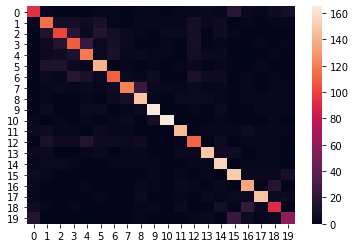

In [25]:
print("Classification report:")
print(classification_report(Y_test, Y_test_hat, target_names=label_encoder.classes_))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_test, Y_test_hat)))

# Classification with Logistic Regression

In [26]:
clf = LogisticRegression().fit(X_train, Y_train)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Train report:

In [27]:
Y_train_hat = clf.predict(X_train)

Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.91      0.91      0.91       639
           comp.graphics       0.86      0.90      0.88       778
 comp.os.ms-windows.misc       0.86      0.84      0.85       788
comp.sys.ibm.pc.hardware       0.84      0.84      0.84       786
   comp.sys.mac.hardware       0.91      0.91      0.91       770
          comp.windows.x       0.92      0.91      0.91       790
            misc.forsale       0.83      0.90      0.86       780
               rec.autos       0.94      0.94      0.94       792
         rec.motorcycles       0.97      0.96      0.96       797
      rec.sport.baseball       0.97      0.98      0.98       795
        rec.sport.hockey       0.99      0.98      0.99       799
               sci.crypt       0.98      0.94      0.96       793
         sci.electronics       0.89      0.91      0.90       787
                 sci.med       0.96      0.97      0

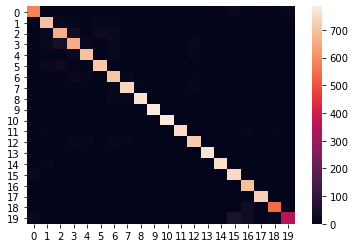

In [28]:
print("Classification report:")
print(classification_report(Y_train, Y_train_hat, target_names=label_encoder.classes_))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_hat)))

#### Test report:

In [29]:
Y_test_hat = clf.predict(X_test)

Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.77      0.76       160
           comp.graphics       0.72      0.83      0.77       195
 comp.os.ms-windows.misc       0.79      0.78      0.78       197
comp.sys.ibm.pc.hardware       0.70      0.69      0.69       196
   comp.sys.mac.hardware       0.83      0.75      0.79       193
          comp.windows.x       0.78      0.80      0.79       198
            misc.forsale       0.80      0.85      0.83       195
               rec.autos       0.85      0.85      0.85       198
         rec.motorcycles       0.94      0.89      0.92       199
      rec.sport.baseball       0.95      0.94      0.95       199
        rec.sport.hockey       0.96      0.93      0.94       200
               sci.crypt       0.95      0.89      0.92       198
         sci.electronics       0.77      0.80      0.79       197
                 sci.med       0.87      0.91      0

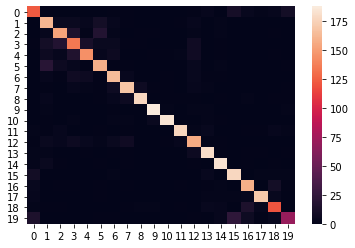

In [30]:
print("Classification report:")
print(classification_report(Y_test, Y_test_hat, target_names=label_encoder.classes_))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_test, Y_test_hat)))